<a href="https://colab.research.google.com/github/almendruki/Cosas-TDA/blob/main/Almendra_Orellana_Figueroa_Clase_4_Tutorial_caracter%C3%ADsticas_topol%C3%B3gicas_en_grafos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Introducción a TDA con Características Topológicas en Grafos
## Análisis Topológico de Datos en grafos

### Objetivos de Aprendizaje
- Entender cómo analizar la estructura de datos usando grafos
- Construir secuencias de grafos a partir de nubes de puntos
- Identificar componentes conectadas y ciclos en grafos
- Observar cómo cambian estas estructuras al variar la escala de conexión

---

## Parte 1: Motivación y Setup

### ¿Por qué estudiar la estructura de los datos con grafos?
Los datos tienen patrones y estructuras que podemos descubrir:
- Grupos de puntos cercanos (clusters)
- Regiones vacías (agujeros)
- Patrones que cambian según la escala que usemos

### Setup del entorno

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import make_circles
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualización
plt.rcParams['figure.figsize'] = (12, 8)

---
## Parte 2: Generación de Datos y Matriz de Distancias

### Crear una nube de puntos



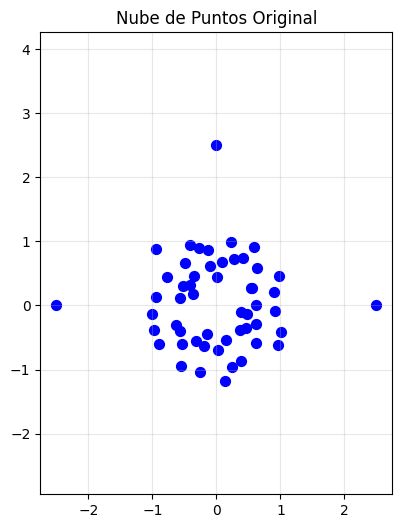

In [ ]:
# Generar datos con estructura topológica interesante
def generar_datos_ejemplo():
    # Círculo con ruido
    X_circle, _ = make_circles(n_samples=50, factor=0.6, noise=0.1, random_state=42)

    # Añadir algunos puntos aislados
    puntos_aislados = np.array([[2.5, 0], [-2.5, 0], [0, 2.5]])
    X = np.vstack([X_circle, puntos_aislados])

    return X

# Generar y visualizar datos
X = generar_datos_ejemplo()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c='blue', s=50)
plt.title('Nube de Puntos Original')
plt.axis('equal')
plt.grid(True, alpha=0.3)

**Pregunta para discusión:** *¿Qué estructuras o patrones puedes identificar visualmente en estos datos?*

### Calcular matriz de distancias

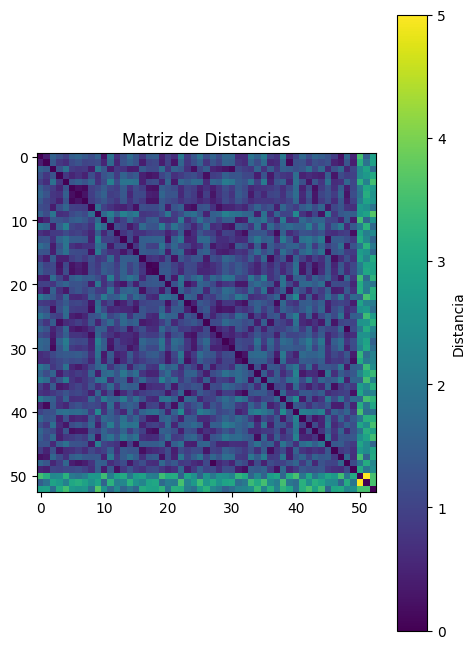

Dimensión de la matriz: (53, 53)
Distancia mínima (no cero): 0.022
Distancia máxima: 5.000


In [ ]:
def calcular_matriz_distancias(X):
    """Calcula la matriz de distancias euclidianas"""
    distancias = pdist(X, metric='euclidean')
    matriz_dist = squareform(distancias)
    return matriz_dist

# Calcular matriz de distancias
D = calcular_matriz_distancias(X)

# Visualizar matriz de distancias
plt.subplot(1, 2, 2)
plt.imshow(D, cmap='viridis')
plt.colorbar(label='Distancia')
plt.title('Matriz de Distancias')
plt.show()

print(f"Dimensión de la matriz: {D.shape}")
print(f"Distancia mínima (no cero): {D[D > 0].min():.3f}")
print(f"Distancia máxima: {D.max():.3f}")

---
## Parte 3: Construcción de Grafos por Escalas

### Generar secuencia de valores epsilon

In [ ]:
def generar_epsilons(D, k=8):
    """Genera k valores de epsilon entre min y max distancias"""
    dist_min = D[D > 0].min()  # Mínima distancia no cero
    dist_max = D.max()         # Máxima distancia

    epsilons = np.linspace(dist_min, dist_max, k)
    return epsilons, dist_min, dist_max

epsilons, d_min, d_max = generar_epsilons(D, k=8)
print("Valores de epsilon:")
for i, eps in enumerate(epsilons):
    print(f"ε_{i+1} = {eps:.3f}")

Valores de epsilon:
ε_1 = 0.022
ε_2 = 0.734
ε_3 = 1.445
ε_4 = 2.156
ε_5 = 2.867
ε_6 = 3.578
ε_7 = 4.289
ε_8 = 5.000


### Construir grafos por cada valor de epsilon

In [ ]:
def construir_grafo_epsilon(X, D, epsilon):
    """Construye un grafo donde hay arista si distancia <= epsilon"""
    n = len(X)
    G = nx.Graph()

    # Añadir nodos
    for i in range(n):
        G.add_node(i, pos=X[i])

    # Añadir aristas
    for i in range(n):
        for j in range(i + 1, n):
            if D[i, j] <= epsilon:
                G.add_edge(i, j)

    return G

# Construir grafos para diferentes epsilons
grafos = []
for eps in epsilons:
    G = construir_grafo_epsilon(X, D, eps)
    grafos.append(G)

**Pregunta para discusión:** *¿Qué esperas que pase con los grafos a medida que epsilon aumenta?*

### Visualizar evolución de grafos

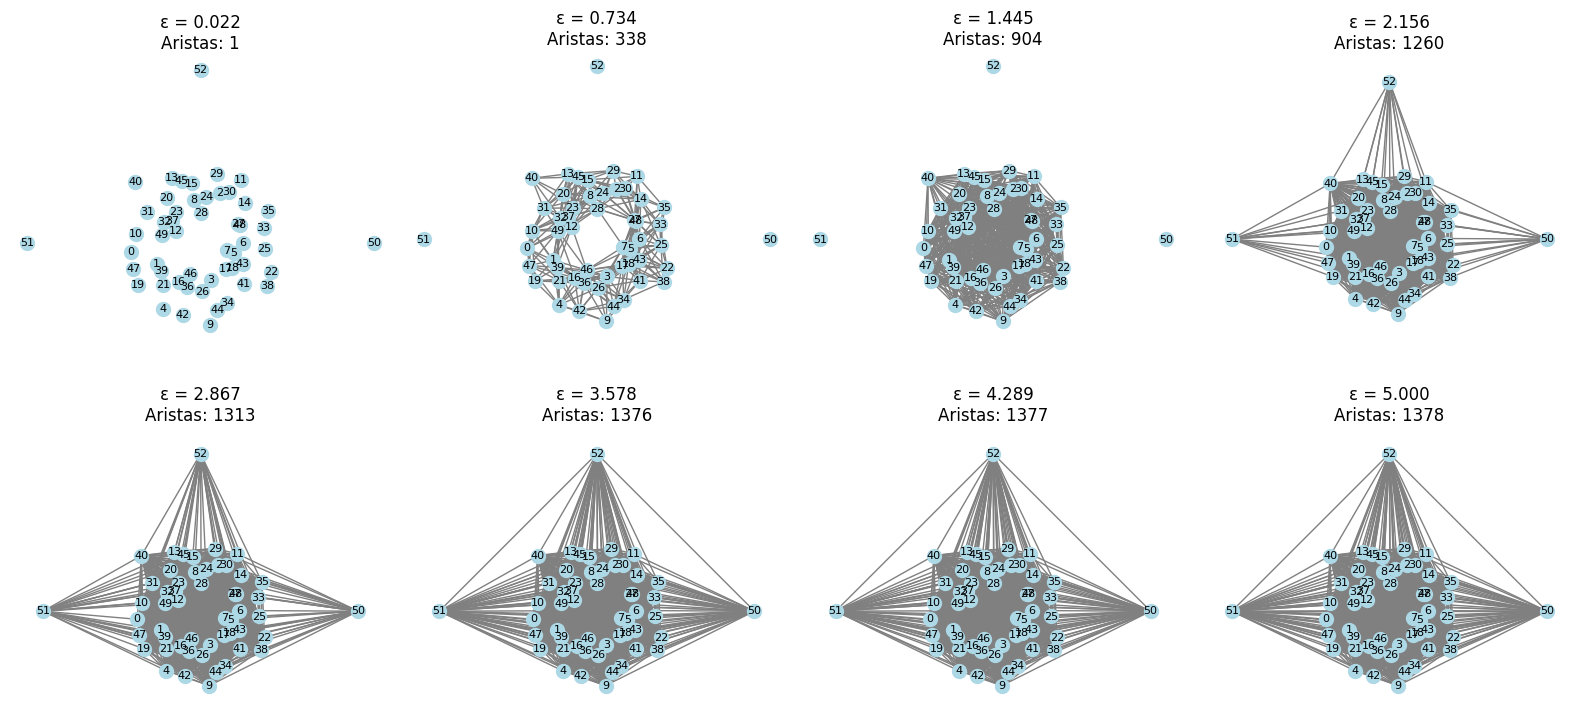

In [ ]:
def visualizar_grafos_secuencia(X, grafos, epsilons):
    """Visualiza la secuencia de grafos"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, (G, eps) in enumerate(zip(grafos, epsilons)):
        ax = axes[i]

        # Posiciones de los nodos
        pos = {node: X[node] for node in G.nodes()}

        # Dibujar grafo
        nx.draw(G, pos, ax=ax, node_color='lightblue', edge_color='gray',
                node_size=100, with_labels=True, font_size=8)

        ax.set_title(f'ε = {eps:.3f}\nAristas: {G.number_of_edges()}')
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

visualizar_grafos_secuencia(X, grafos, epsilons)

---
## Parte 4: Análisis de Componentes Conectadas

### Contar componentes conectadas

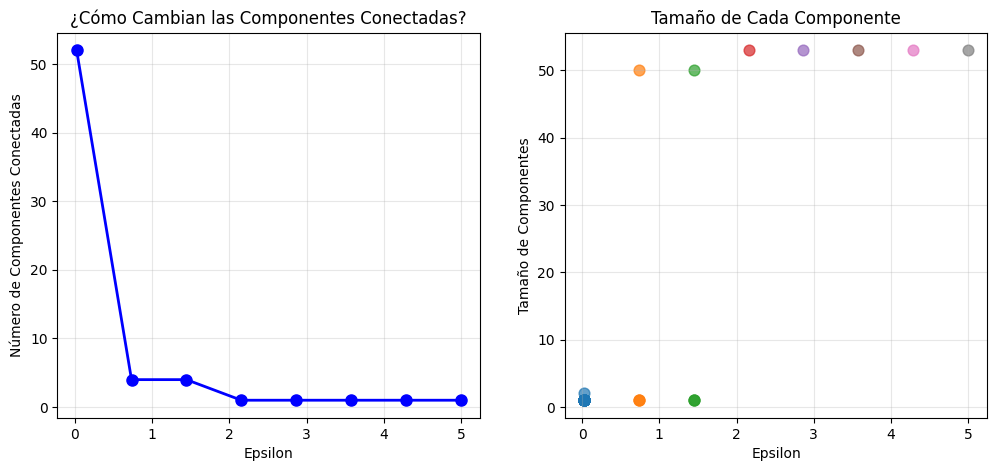

Evolución del número de componentes:
ε = 0.022: 52 componentes
ε = 0.734: 4 componentes
ε = 1.445: 4 componentes
ε = 2.156: 1 componentes
ε = 2.867: 1 componentes
ε = 3.578: 1 componentes
ε = 4.289: 1 componentes
ε = 5.000: 1 componentes


In [ ]:
def analizar_componentes_conectadas(grafos, epsilons):
    """Analiza cómo cambian las componentes conectadas"""
    num_componentes = []
    tamaños_componentes = []

    for G in grafos:
        componentes = list(nx.connected_components(G))
        num_componentes.append(len(componentes))
        tamaños = [len(comp) for comp in componentes]
        tamaños_componentes.append(tamaños)

    return num_componentes, tamaños_componentes

num_comp, tamaños_comp = analizar_componentes_conectadas(grafos, epsilons)

# Visualizar evolución
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epsilons, num_comp, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon')
plt.ylabel('Número de Componentes Conectadas')
plt.title('¿Cómo Cambian las Componentes Conectadas?')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for i, (eps, tamaños) in enumerate(zip(epsilons, tamaños_comp)):
    plt.scatter([eps] * len(tamaños), tamaños, alpha=0.7, s=60)
plt.xlabel('Epsilon')
plt.ylabel('Tamaño de Componentes')
plt.title('Tamaño de Cada Componente')
plt.grid(True, alpha=0.3)
plt.show()

print("Evolución del número de componentes:")
for i, (eps, n_comp) in enumerate(zip(epsilons, num_comp)):
    print(f"ε = {eps:.3f}: {n_comp} componentes")

**Pregunta para reflexión:** *¿Por qué disminuye el número de componentes conectadas a medida que epsilon aumenta?*

---
## Parte 5: Análisis de Ciclos en los Grafos
### Detectar ciclos

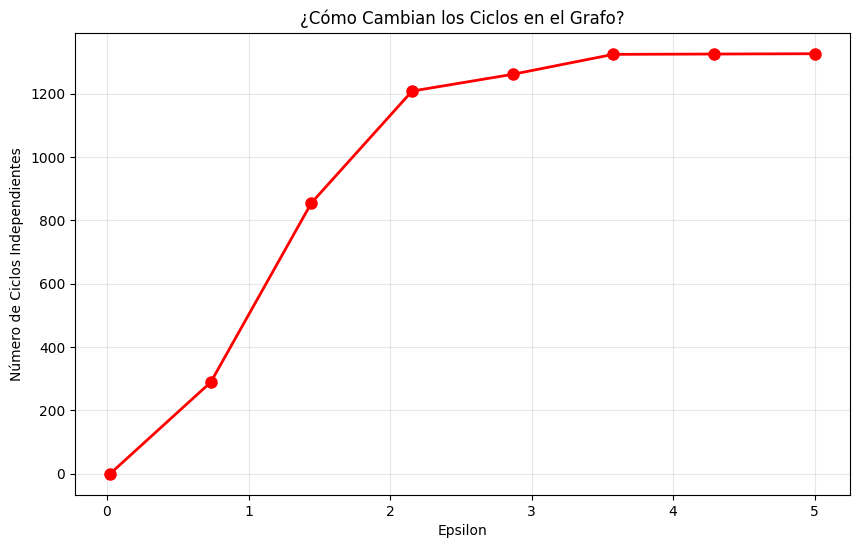

Análisis de ciclos:
ε = 0.022: 0 ciclos (1 aristas - 53 nodos + 52 comp)
ε = 0.734: 289 ciclos (338 aristas - 53 nodos + 4 comp)
ε = 1.445: 855 ciclos (904 aristas - 53 nodos + 4 comp)
ε = 2.156: 1208 ciclos (1260 aristas - 53 nodos + 1 comp)
ε = 2.867: 1261 ciclos (1313 aristas - 53 nodos + 1 comp)
ε = 3.578: 1324 ciclos (1376 aristas - 53 nodos + 1 comp)
ε = 4.289: 1325 ciclos (1377 aristas - 53 nodos + 1 comp)
ε = 5.000: 1326 ciclos (1378 aristas - 53 nodos + 1 comp)


In [ ]:
def analizar_ciclos(grafos, epsilons):
    """Analiza cómo cambian los ciclos en los grafos"""
    info_ciclos = []

    for i, G in enumerate(grafos):
        # Para contar ciclos independientes en un grafo conectado:
        # número de ciclos = número de aristas - número de nodos + número de componentes
        n_nodos = G.number_of_nodes()
        n_aristas = G.number_of_edges()
        n_componentes = nx.number_connected_components(G)

        # Número de ciclos independientes que se pueden formar
        num_ciclos = n_aristas - n_nodos + n_componentes

        info_ciclos.append({
            'epsilon': epsilons[i],
            'nodos': n_nodos,
            'aristas': n_aristas,
            'componentes': n_componentes,
            'ciclos': num_ciclos
        })

    return info_ciclos

info_ciclos = analizar_ciclos(grafos, epsilons)

# Visualizar
ciclos = [info['ciclos'] for info in info_ciclos]
plt.figure(figsize=(10, 6))
plt.plot(epsilons, ciclos, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Epsilon')
plt.ylabel('Número de Ciclos Independientes')
plt.title('¿Cómo Cambian los Ciclos en el Grafo?')
plt.grid(True, alpha=0.3)
plt.show()

print("Análisis de ciclos:")
for info in info_ciclos:
    print(f"ε = {info['epsilon']:.3f}: {info['ciclos']} ciclos "
          f"({info['aristas']} aristas - {info['nodos']} nodos + {info['componentes']} comp)")

---
## Parte 6: Síntesis y Reflexiones

### Resumen de lo observado

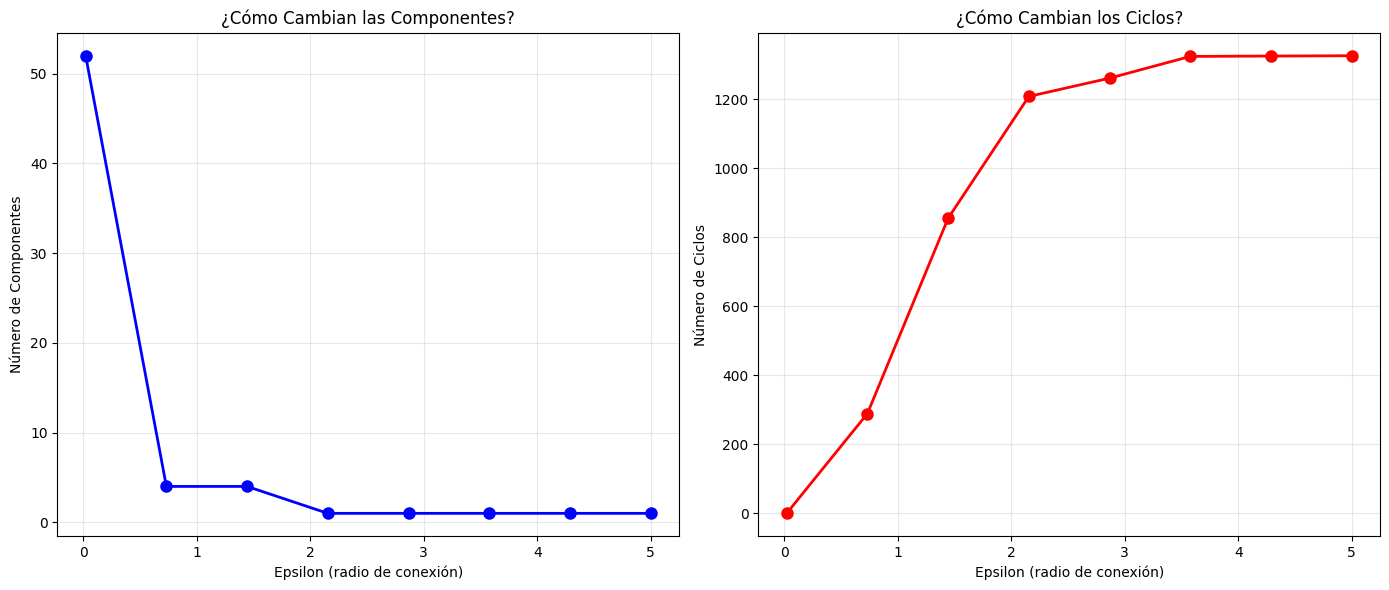

In [ ]:
def crear_resumen_grafos(info_ciclos):
    """Crea un resumen de cómo cambian los grafos"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    epsilons = [info['epsilon'] for info in info_ciclos]
    componentes = [info['componentes'] for info in info_ciclos]
    ciclos = [info['ciclos'] for info in info_ciclos]

    # Componentes conectadas
    ax1.plot(epsilons, componentes, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Epsilon (radio de conexión)')
    ax1.set_ylabel('Número de Componentes')
    ax1.set_title('¿Cómo Cambian las Componentes?')
    ax1.grid(True, alpha=0.3)

    # Ciclos
    ax2.plot(epsilons, ciclos, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Epsilon (radio de conexión)')
    ax2.set_ylabel('Número de Ciclos')
    ax2.set_title('¿Cómo Cambian los Ciclos?')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

crear_resumen_grafos(info_ciclos)

### Reflexiones Finales

In [ ]:
print("¿QUÉ HEMOS DESCUBIERTO?")
print("="*50)
print("1. Los datos tienen estructura que podemos capturar con grafos")
print("2. Al cambiar el radio de conexión (ε), vemos diferentes aspectos:")
print("   • Componentes conectadas: grupos de puntos unidos")
print("   • Ciclos: 'agujeros' o bucles en la estructura")
print("3. Estas estructuras cambian de manera predecible:")
print("   • Más conexiones → menos componentes separadas")
print("   • Primero aparecen conexiones, luego ciclos")
print("\n PATRONES OBSERVADOS:")
print("• Las componentes conectadas tienden a DISMINUIR")
print("• Los ciclos primero AUMENTAN, luego pueden cambiar")
print("• Cada valor de ε nos muestra una 'vista' diferente de los datos")

¿QUÉ HEMOS DESCUBIERTO?
1. Los datos tienen estructura que podemos capturar con grafos
2. Al cambiar el radio de conexión (ε), vemos diferentes aspectos:
   • Componentes conectadas: grupos de puntos unidos
   • Ciclos: 'agujeros' o bucles en la estructura
3. Estas estructuras cambian de manera predecible:
   • Más conexiones → menos componentes separadas
   • Primero aparecen conexiones, luego ciclos

 PATRONES OBSERVADOS:
• Las componentes conectadas tienden a DISMINUIR
• Los ciclos primero AUMENTAN, luego pueden cambiar
• Cada valor de ε nos muestra una 'vista' diferente de los datos


## Preguntas para Reflexionar

1. **¿Qué pasa con las componentes?**: ¿Por qué el número de componentes conectadas disminuye cuando aumentamos ε?

2. **¿Cuándo aparecen los ciclos?**: ¿En qué valores de ε empezamos a ver ciclos? ¿Por qué?

3. **Información vs. Escala**: ¿Qué información perdemos o ganamos al usar valores de ε muy pequeños vs. muy grandes?

4. **Robustez**: Si añadiéramos un poco de ruido a los datos, ¿cómo crees que cambiarían estos patrones?

## Ejercicios para Casa

1. **Experimenta con diferentes formas**: Prueba con datos que formen líneas, múltiples círculos, o formas más complejas.

2. **Optimización del radio de conexión**: ¿Cómo elegirías los valores de epsilon de manera más inteligente?

3. **Estructuras 3D**: ¿Cómo podrías adaptar este análisis para datos en 3D?

4. **Efecto del ruido**: Añade ruido gaussiano a los datos y observa cómo cambian los patrones.

## Recursos Adicionales

- Documentación de NetworkX para análisis de grafos
- Sklearn para generación de datasets sintéticos